In [1]:
import os
import sys
from collections import OrderedDict
import torch
import torchvision
import torchvision.models
from torch.utils import model_zoo

In [2]:
def load_model(model_name):

    model_urls = {
            'resnet50_trained_on_SIN': 'https://bitbucket.org/robert_geirhos/texture-vs-shape-pretrained-models/raw/6f41d2e86fc60566f78de64ecff35cc61eb6436f/resnet50_train_60_epochs-c8e5653e.pth.tar',
            'resnet50_trained_on_SIN_and_IN': 'https://bitbucket.org/robert_geirhos/texture-vs-shape-pretrained-models/raw/60b770e128fffcbd8562a3ab3546c1a735432d03/resnet50_train_45_epochs_combined_IN_SF-2a0d100e.pth.tar',
            'resnet50_trained_on_SIN_and_IN_then_finetuned_on_IN': 'https://bitbucket.org/robert_geirhos/texture-vs-shape-pretrained-models/raw/60b770e128fffcbd8562a3ab3546c1a735432d03/resnet50_finetune_60_epochs_lr_decay_after_30_start_resnet50_train_45_epochs_combined_IN_SF-ca06340c.pth.tar',
              'vgg16_trained_on_SIN': 'https://bitbucket.org/robert_geirhos/texture-vs-shape-pretrained-models/raw/0008049cd10f74a944c6d5e90d4639927f8620ae/vgg16_train_60_epochs_lr0.01-6c6fcc9f.pth.tar',
            'alexnet_trained_on_SIN': 'https://bitbucket.org/robert_geirhos/texture-vs-shape-pretrained-models/raw/0008049cd10f74a944c6d5e90d4639927f8620ae/alexnet_train_60_epochs_lr0.001-b4aa5238.pth.tar',
    }

    if "resnet50" in model_name:
        print("Using the ResNet50 architecture.")
        model = torchvision.models.resnet50(pretrained=False)
        model = torch.nn.DataParallel(model).cuda()
        checkpoint = model_zoo.load_url(model_urls[model_name])
    elif "vgg16" in model_name:
        print("Using the VGG-16 architecture.")
       
        # download model from URL manually and save to desired location
        filepath = "./vgg16_train_60_epochs_lr0.01-6c6fcc9f.pth.tar"

        assert os.path.exists(filepath), "Please download the VGG model yourself from the following link and save it locally: https://drive.google.com/drive/folders/1A0vUWyU6fTuc-xWgwQQeBvzbwi6geYQK (too large to be downloaded automatically like the other models)"

        model = torchvision.models.vgg16(pretrained=False)
        model.features = torch.nn.DataParallel(model.features)
        model.cuda()
        checkpoint = torch.load(filepath)


    elif "alexnet" in model_name:
        print("Using the AlexNet architecture.")
        model = torchvision.models.alexnet(pretrained=False)
        model.features = torch.nn.DataParallel(model.features)
        model.cuda()
        checkpoint = model_zoo.load_url(model_urls[model_name])
    else:
        raise ValueError("unknown model architecture.")

    model.load_state_dict(checkpoint["state_dict"])
    return model



In [3]:
model_E = "resnet50_trained_on_SIN"

In [4]:
model = load_model(model_E)

Using the ResNet50 architecture.


In [5]:
import untangle

In [6]:
from torchvision import models
import numpy as np
import torch
from torchvision import transforms
import PIL
import os
from IPython.display import Image
from untangle import UntangleAI
untangle_ai = UntangleAI() # load and define our package api

In [7]:
class Args:
    mname = 'resnet50'
    img_size = (3,224,224) # a 3-tuple of (CHW)
    num_classes = 1000
    method = 'vanillaGrad' # one of `vanillaGrad`, `deConvNet`, `guided_bp`, `gradcam`, `saliencyGrad`, `integratedGrad` `smoothgrad`
    topk = 5
    cmap = 'seismic'
    json = False
    hm_diff = 'joint'

    target_layer_idx = ["35"] # only for gradcam

    steps = 50 # only for integrated gradients
    baseline = None # torch tensor (of shape `input_tensor`) only for integrated gradients

    base_method = 'guided_bp' # only for smooth grad
    stdev_spread = 0.25 # only for smooth grad
    nsamples = 25 # only for smooth grad
    magnitude = True # only for smooth grad

args = Args()
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
module_path = os.path.realpath('.')
results_path = os.path.join(module_path, 'baseline_results')
if(not os.path.exists(results_path)):
    os.makedirs(results_path)
out_prefix = os.path.join(results_path, '{}_{}'.format(args.mname, args.method))

In [8]:
def load_adHoc_image(img_path, img_size=(224,224,3)):
    img_transform = transforms.Compose([
        transforms.Resize((img_size[0]+32, img_size[1]+32)),
        transforms.CenterCrop((img_size[0], img_size[1])),
    ])
    tensor_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
    if(not os.path.exists(img_path)):
        raise FileNotFoundError(img_path)
    inp_image = PIL.Image.open(img_path)
    inp_image = inp_image.convert("RGB")
    crop_inp_image = img_transform(inp_image)
    input_tensor = tensor_transform(crop_inp_image)
    input_tensor = input_tensor.unsqueeze(0)
    if (torch.cuda.is_available()):
        input_tensor = input_tensor.cuda()
    return(input_tensor, crop_inp_image)

In [9]:
!pwd

/home/jupyter/texture-vs-shape/models


In [10]:
model = load_model(model_E)
model.eval()
img_path = '../../Scuba_Shark.jpg'
input_tensor, input_img = load_adHoc_image(img_path)
input_tensor = input_tensor.to(DEVICE)
input_img = np.asarray(input_img)

Using the ResNet50 architecture.


In [11]:
untangle_ai.vanillaGrad(model, input_tensor, input_img, out_prefix, args)

Top-5 class(es): ['2', '3', '983', '4', '149']
Top-5 logit(s): [16.918777, 15.500191, 14.35429, 14.122624, 11.684149]
Top-5 probs(s): [0.7195689, 0.17417589, 0.055377025, 0.043925684, 0.003834441]
class_0 specific heatmap saved in path: `/home/jupyter/texture-vs-shape/models/baseline_results/resnet50_vanillaGrad_class_0.JPEG`
class_1 specific heatmap saved in path: `/home/jupyter/texture-vs-shape/models/baseline_results/resnet50_vanillaGrad_class_1.JPEG`
class_2 specific heatmap saved in path: `/home/jupyter/texture-vs-shape/models/baseline_results/resnet50_vanillaGrad_class_2.JPEG`
class_3 specific heatmap saved in path: `/home/jupyter/texture-vs-shape/models/baseline_results/resnet50_vanillaGrad_class_3.JPEG`
class_4 specific heatmap saved in path: `/home/jupyter/texture-vs-shape/models/baseline_results/resnet50_vanillaGrad_class_4.JPEG`
difference heatmap estimation
class_1 specific diff heatmap saved in path: `/home/jupyter/texture-vs-shape/models/baseline_results/resnet50_vanillaG

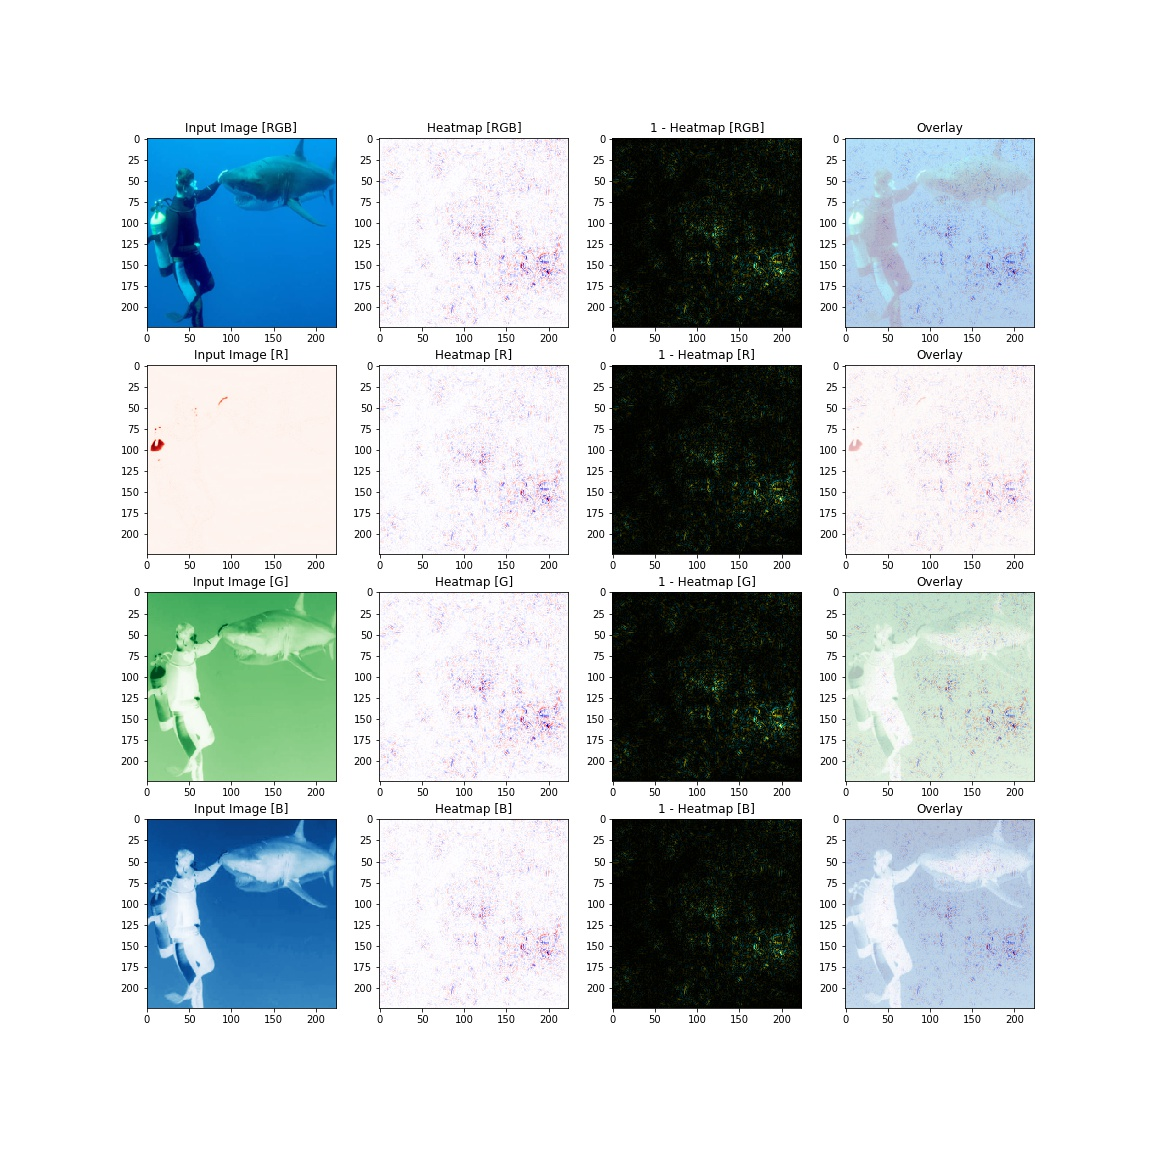

In [12]:
Image('/home/jupyter/texture-vs-shape/models/baseline_results/resnet50_vanillaGrad_class_0.JPEG')

In [13]:
model = load_model(model_E)
model.eval()
args.method = 'deConvNet'
out_prefix = os.path.join(results_path, '{}_{}'.format(args.mname, args.method))
untangle_ai.deConvNet(model, input_tensor, input_img, out_prefix, args)

Using the ResNet50 architecture.
Top-5 class(es): ['2', '3', '983', '4', '149']
Top-5 logit(s): [16.918777, 15.500191, 14.35429, 14.122624, 11.684149]
Top-5 probs(s): [0.7195689, 0.17417589, 0.055377025, 0.043925684, 0.003834441]
class_0 specific heatmap saved in path: `/home/jupyter/texture-vs-shape/models/baseline_results/resnet50_deConvNet_class_0.JPEG`
class_1 specific heatmap saved in path: `/home/jupyter/texture-vs-shape/models/baseline_results/resnet50_deConvNet_class_1.JPEG`
class_2 specific heatmap saved in path: `/home/jupyter/texture-vs-shape/models/baseline_results/resnet50_deConvNet_class_2.JPEG`
class_3 specific heatmap saved in path: `/home/jupyter/texture-vs-shape/models/baseline_results/resnet50_deConvNet_class_3.JPEG`
class_4 specific heatmap saved in path: `/home/jupyter/texture-vs-shape/models/baseline_results/resnet50_deConvNet_class_4.JPEG`
difference heatmap estimation
class_1 specific diff heatmap saved in path: `/home/jupyter/texture-vs-shape/models/baseline_re

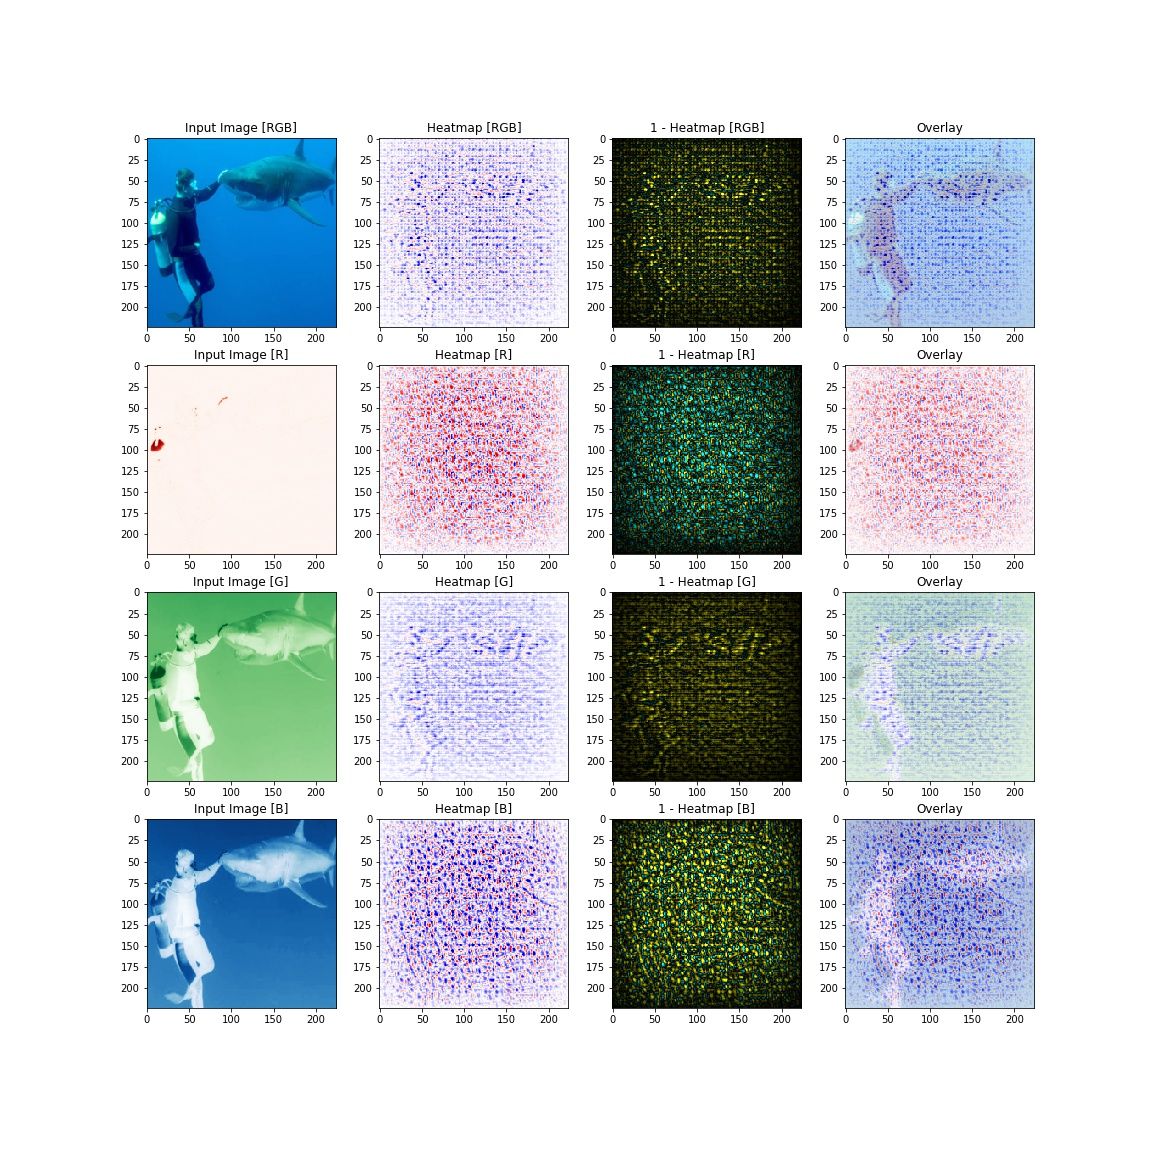

In [14]:
Image('/home/jupyter/texture-vs-shape/models/baseline_results/resnet50_deConvNet_class_0.JPEG')

In [15]:
model = load_model(model_E)
model.eval()
args.method = 'guided_bp'
out_prefix = os.path.join(results_path, '{}_{}'.format(args.mname, args.method))
untangle_ai.guided_bp(model, input_tensor, input_img, out_prefix, args)

Using the ResNet50 architecture.
Top-5 class(es): ['2', '3', '983', '4', '149']
Top-5 logit(s): [16.918777, 15.500191, 14.35429, 14.122624, 11.684149]
Top-5 probs(s): [0.7195689, 0.17417589, 0.055377025, 0.043925684, 0.003834441]
class_0 specific heatmap saved in path: `/home/jupyter/texture-vs-shape/models/baseline_results/resnet50_guided_bp_class_0.JPEG`
class_1 specific heatmap saved in path: `/home/jupyter/texture-vs-shape/models/baseline_results/resnet50_guided_bp_class_1.JPEG`
class_2 specific heatmap saved in path: `/home/jupyter/texture-vs-shape/models/baseline_results/resnet50_guided_bp_class_2.JPEG`
class_3 specific heatmap saved in path: `/home/jupyter/texture-vs-shape/models/baseline_results/resnet50_guided_bp_class_3.JPEG`
class_4 specific heatmap saved in path: `/home/jupyter/texture-vs-shape/models/baseline_results/resnet50_guided_bp_class_4.JPEG`
difference heatmap estimation
class_1 specific diff heatmap saved in path: `/home/jupyter/texture-vs-shape/models/baseline_re

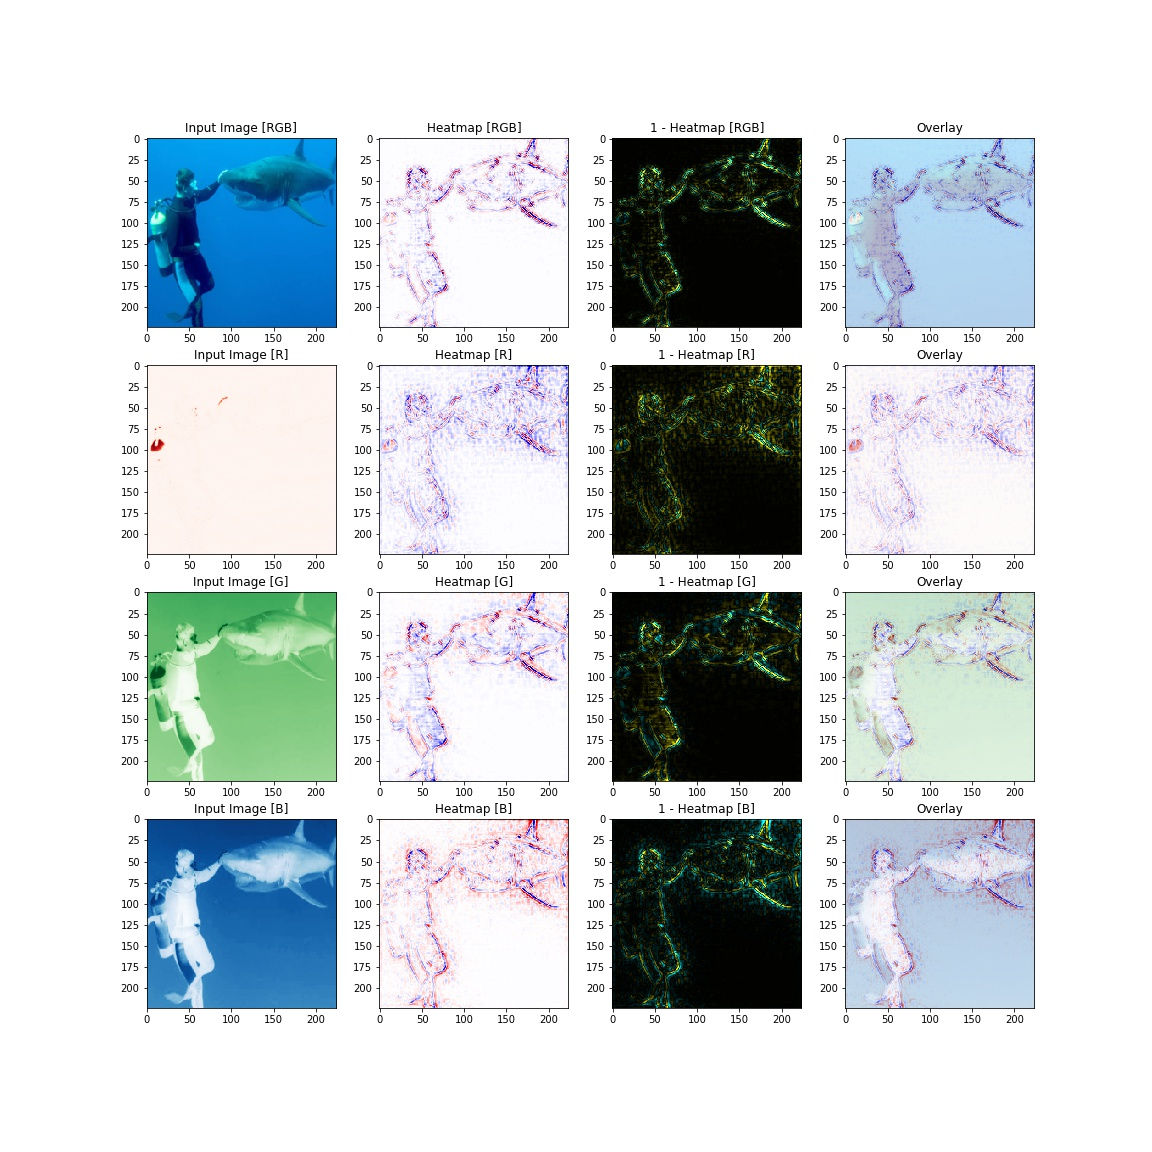

In [16]:
Image('/home/jupyter/texture-vs-shape/models/baseline_results/resnet50_guided_bp_class_0.JPEG')

In [17]:
model = load_model(model_E)
model.eval()
args.method = 'saliencyGrad'
out_prefix = os.path.join(results_path, '{}_{}'.format(args.mname, args.method))
untangle_ai.saliencyGrad(model, input_tensor, input_img, out_prefix, args)

Using the ResNet50 architecture.
Top-5 class(es): ['2', '3', '983', '4', '149']
Top-5 logit(s): [16.918777, 15.500191, 14.35429, 14.122624, 11.684149]
Top-5 probs(s): [0.7195689, 0.17417589, 0.055377025, 0.043925684, 0.003834441]
class_0 specific heatmap saved in path: `/home/jupyter/texture-vs-shape/models/baseline_results/resnet50_saliencyGrad_class_0.JPEG`
class_1 specific heatmap saved in path: `/home/jupyter/texture-vs-shape/models/baseline_results/resnet50_saliencyGrad_class_1.JPEG`
class_2 specific heatmap saved in path: `/home/jupyter/texture-vs-shape/models/baseline_results/resnet50_saliencyGrad_class_2.JPEG`
class_3 specific heatmap saved in path: `/home/jupyter/texture-vs-shape/models/baseline_results/resnet50_saliencyGrad_class_3.JPEG`
class_4 specific heatmap saved in path: `/home/jupyter/texture-vs-shape/models/baseline_results/resnet50_saliencyGrad_class_4.JPEG`
difference heatmap estimation
class_1 specific diff heatmap saved in path: `/home/jupyter/texture-vs-shape/mod

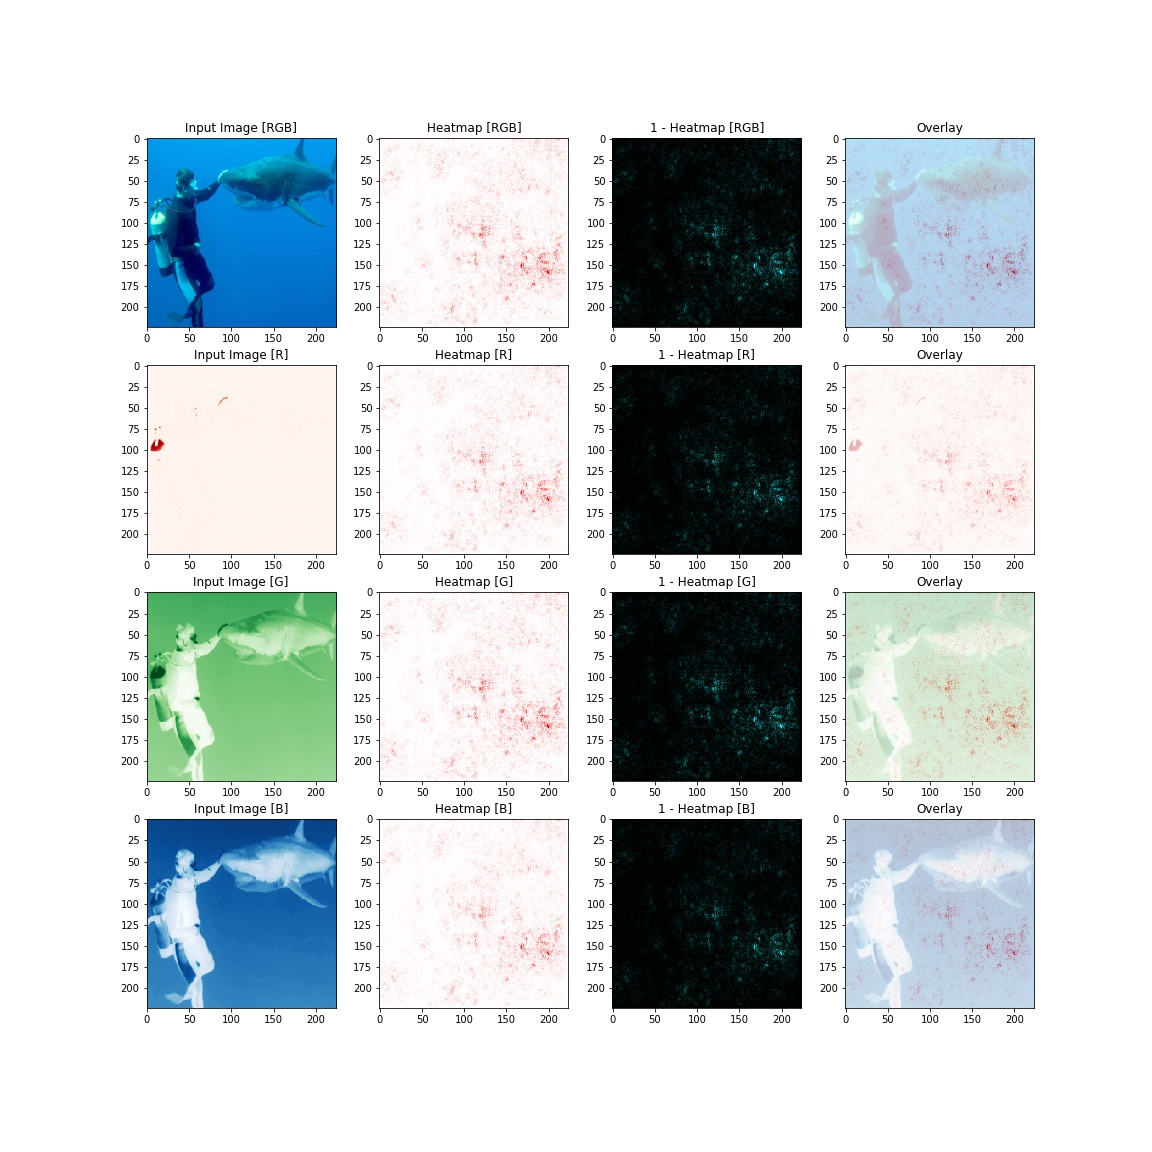

In [18]:
Image('/home/jupyter/texture-vs-shape/models/baseline_results/resnet50_saliencyGrad_class_0.JPEG')

In [ ]:
model = load_model(model_E)
model.eval()
args.method = 'integratedGrad'
out_prefix = os.path.join(results_path, '{}_{}'.format(args.mname, args.method))
untangle_ai.integratedGrad(model, input_tensor, input_img, out_prefix, args)

Using the ResNet50 architecture.
Top-5 class(es): ['2', '3', '983', '4', '149']
Top-5 logit(s): [16.918777, 15.500191, 14.35429, 14.122624, 11.684149]
Top-5 probs(s): [0.7195689, 0.17417589, 0.055377025, 0.043925684, 0.003834441]
class_0 specific heatmap saved in path: `/home/jupyter/texture-vs-shape/models/baseline_results/resnet50_integratedGrad_class_0.JPEG`
class_1 specific heatmap saved in path: `/home/jupyter/texture-vs-shape/models/baseline_results/resnet50_integratedGrad_class_1.JPEG`
class_2 specific heatmap saved in path: `/home/jupyter/texture-vs-shape/models/baseline_results/resnet50_integratedGrad_class_2.JPEG`
class_3 specific heatmap saved in path: `/home/jupyter/texture-vs-shape/models/baseline_results/resnet50_integratedGrad_class_3.JPEG`
class_4 specific heatmap saved in path: `/home/jupyter/texture-vs-shape/models/baseline_results/resnet50_integratedGrad_class_4.JPEG`
difference heatmap estimation
class_1 specific diff heatmap saved in path: `/home/jupyter/texture-vs

In [ ]:
Image('/home/jupyter/texture-vs-shape/models/baseline_results/resnet50_integratedGrad_class_0.JPEG')

In [ ]:
model_E = "resnet50_trained_on_SIN"
model = load_model(model_E)
model.eval()
args.method = 'smoothgrad'
args.base_method = 'integratedGrad'
stdev_spread = 0.05
nsamples = 25
magnitude = False

out_prefix = os.path.join(results_path, '{}_{}_{}'.format(args.mname, args.base_method, args.method))
base_explainer = untangle_ai.get_explainer(args.base_method, model, args)
untangle_ai.smoothgrad(model, base_explainer, input_tensor, input_img, out_prefix, args)

In [ ]:
Image('/home/jupyter/texture-vs-shape/models/baseline_results/resnet50_integratedGrad_smoothgrad_class_0.JPEG')

In [ ]:
model = load_model(model_E)
model.eval()
args.method = 'smoothgrad'
args.base_method = 'guided_bp'
args.nsamples = 10 
out_prefix = os.path.join(results_path, '{}_{}_{}'.format(args.mname, args.base_method, args.method))
base_explainer = untangle_ai.get_explainer(args.base_method, model, args)
untangle_ai.smoothgrad(model, base_explainer, input_tensor, input_img, out_prefix, args)

In [ ]:
Image('/home/jupyter/texture-vs-shape/models/baseline_results/resnet50_guided_bp_smoothgrad_class_0.JPEG')